In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import persepctiveTransform

In [3]:
cap = cv2.VideoCapture("./2021-07-27 12-26-46.mp4")
cap.isOpened()

True

In [4]:
fps = cap.get(cv2.CAP_PROP_FPS)

## Sample frame

In [5]:
cap.set(1, 3)
ret, frame = cap.read()
image = Image.fromarray(frame)
image.show()

## Get reference points
### Pick reference points from video

In [6]:
ori_coord = persepctiveTransform.GetReferences(frame)

[[83, 540]]
[[83, 540], [779, 538]]
[[83, 540], [779, 538], [686, 464]]
[[83, 540], [779, 538], [686, 464], [185, 460]]


## Note: two ways for transformation
### 1. Set up coordinates according to the 

In [7]:
# transformed = np.float32([[0, 0], 
#                           [2000,0], 
#                           [2000,1000], 
#                           [0,1000]])

In [8]:
x_min = min(ori_coord[:,0])
x_max = max(ori_coord[:,0])
y_min = min(ori_coord[:,1])
y_max = max(ori_coord[:,1])

constant = 2000

dx = x_max - x_min
dx_real = 2
x_ratio = dx_real/dx

dy = y_max - y_min
dy_real = 1
y_ratio = dy_real/dy


transformed = np.float32([[x_min + constant, y_max + constant], 
                          [x_max + constant, y_max + constant], 
                          [x_max + constant, y_min + constant], 
                          [x_min + constant, y_min + constant]])

## Get transformation matrix

In [9]:
M = cv2.getPerspectiveTransform(ori_coord,transformed)
M

array([[-7.55540089e-01, -9.72936110e+00,  2.89800600e+03],
       [ 3.64478930e-01, -1.10489887e+01,  2.98702335e+03],
       [ 1.44431762e-04, -4.02422564e-03,  1.00000000e+00]])

## Show projected frame

In [10]:
figure_size = (4000,4000)

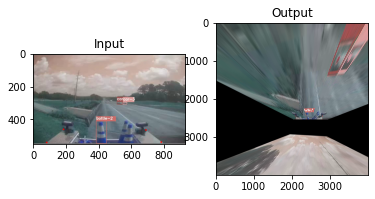

In [11]:
dst = cv2.warpPerspective(frame, M, figure_size)
plt.subplot(121),plt.imshow(frame),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [12]:
image = Image.fromarray(dst)
image.show()

## Sample point

In [13]:
single_veh = np.float32([506, 307])

In [14]:
homg_point = [single_veh[0], single_veh[1], 1] # homogeneous coords
transf_homg_point = M.dot(homg_point) # transform
transf_homg_point /= transf_homg_point[2] # scale
transf_point = transf_homg_point[:2] # remove Cartesian coords
transf_point = transf_point.astype(int)
transf_point = tuple(transf_point)

## Show sample point on the projected figure

In [15]:
img = cv2.circle(dst, transf_point, 10,(255,0,0),-1)
scale_width = 640 / img.shape[1]
scale_height = 480 / img.shape[0]
scale = min(scale_width, scale_height)
window_width = int(img.shape[1] * scale)
window_height = int(img.shape[0] * scale)
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', window_width, window_height)
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Load Data

In [15]:
import process_speed

In [16]:
trajectory = pd.read_csv('2021-07-27 12-26-46.mp4.csv', header = None)
trajectory.columns = ['frame','ID','type','minx','miny','maxx','maxy']

## Calculate speed

In [17]:
df_speed = process_speed.cal_speed(trajectory,M)

In [41]:
df_speed['real_speed'] = df_speed['speed']*24*3.6/1000*0.62

In [42]:
df_speed = df_speed.replace(np.nan, 0)
filter_1 = (df_speed['real_speed']>=10) & (df_speed['real_speed']< 180) & (df_speed['type'] == 'car')
filtered_1 = df_speed[filter_1]

filter_2 = (df_speed['type'] == 'car')
filtered_2 = df_speed[filter_2]

array([<AxesSubplot:title={'center':'real_speed'}>], dtype=object)

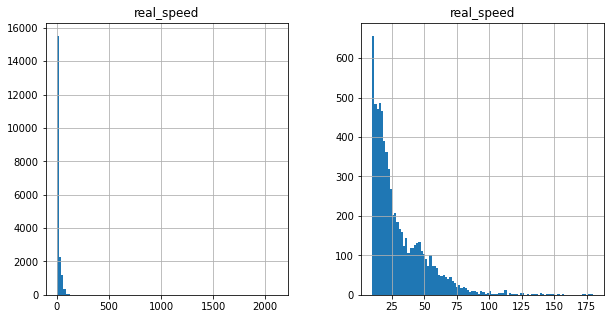

In [43]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
filtered_2.hist(column="real_speed",bins=100,ax=axs[0])
filtered_1.hist(column="real_speed",bins=100,ax=axs[1])

## Zoom into one vehicle

In [44]:
df_speed[df_speed["ID"] == 27]

,frame,ID,type,minx,miny,maxx,maxy,transformed_x,transformed_y,distance,speed,real_speed
0,298,27,car,472,276,509,299,3143.0,20795.0,0.000000,0.000000,0.000000
1,299,27,car,474,276,511,299,3200.0,20834.0,69.065187,69.065187,3.699684
2,300,27,car,475,276,512,299,3229.0,20854.0,35.227830,35.227830,1.887084
3,301,27,car,475,276,512,299,3229.0,20854.0,0.000000,0.000000,0.000000
4,302,27,car,476,276,512,299,3229.0,20854.0,0.000000,0.000000,0.000000
5,303,27,car,478,276,515,299,3315.0,20914.0,104.861814,104.861814,5.617238
6,304,27,car,479,276,516,299,3344.0,20934.0,35.227830,35.227830,1.887084
7,305,27,car,479,276,517,299,3373.0,20954.0,35.227830,35.227830,1.887084
8,306,27,car,479,276,518,300,3320.0,20195.0,760.848211,760.848211,40.757117
9,308,27,car,481,277,522,302,3277.0,18849.0,1346.686675,673.343337,36.069656
